<a href="https://colab.research.google.com/github/yangchangnaihoby/AI_7th/blob/master/Project_004_CV_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytesseract
!pip install opencv-python
!pip install imutils

In [ ]:
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np

pytesseract.pytesseract.tesseract_cmd = R'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [ ]:
def plt_imshow(title = 'image', img = None, figsize = (8, 5)) :
    
    plt.figure(figsize = figsize)

    if type(img) == list :
        
        if type(title) == list :
            titles = title
        else :
            titles = []
            for i in range(len(img)) :
                titles.append(title)
 
        for i in range(len(img)) :
            if len(img[i].shape) <= 2 :
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    
    else :
        
        if len(img.shape) < 3 :
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

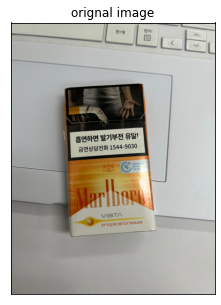

In [ ]:
file_path = 'cvimage/sample_3.jpg'
 
with open(file_path, 'rb') as f :
    data = f.read()
    
image_nparray = np.frombuffer(data, dtype = np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
 
plt_imshow('orignal image', org_image)

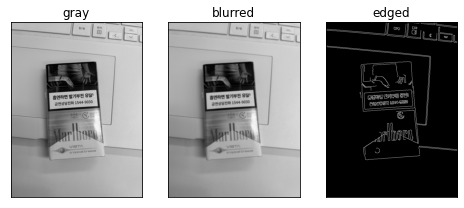

In [ ]:
image = org_image.copy()
image = imutils.resize(image, width = 500)
ratio = org_image.shape[1] / float(image.shape[1])
 
# 이미지를 grayscale로 변환하고 blur를 적용
# 모서리를 찾기위한 이미지 연산
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5, ), 0)
edged = cv2.Canny(blurred, 75, 200)
 
plt_imshow(['gray', 'blurred', 'edged'], [gray, blurred, edged])

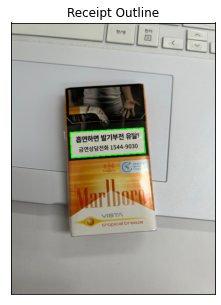

In [ ]:
# contours를 찾아 크기순으로 정렬
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
 
receiptCnt = None
 
# 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
for c in cnts :
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영수증 영역으로 판단하고 break
    if len(approx) == 4 :
        receiptCnt = approx
        break

# 만약 추출한 윤곽이 없을 경우 오류
if receiptCnt is None :
    raise Exception(("Could not find receipt outline."))
    
output = image.copy()
cv2.drawContours(output, [receiptCnt], -1, (0, 255, 0), 2)
plt_imshow("Receipt Outline", output)

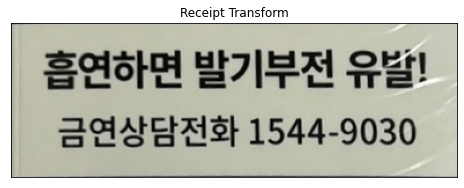

In [ ]:
# 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
receipt = four_point_transform(org_image, receiptCnt.reshape(4, 2) * ratio)
plt_imshow("Receipt Transform", receipt)

In [ ]:
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt, cv2.COLOR_BGR2RGB), lang = 'kor+eng', config = options)
 
# OCR결과 출력
print("[INFO] OCR 결과 :")
print("==================")
print(text)

[INFO] OCR 결과 :
흡연하면 발기부전 유발!

금연상담전화 1544-9030



In [ ]:
def make_scan_image(image, width, ksize = (5, 5), min_threshold = 75, max_threshold = 200) :
    
    image_list_title = []
    image_list = []

    image = imutils.resize(image, width = width)
    ratio = org_image.shape[1] / float(image.shape[1])

    # 이미지를 grayscale로 변환하고 blur를 적용
    # 모서리를 찾기위한 이미지 연산
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blurred, min_threshold, max_threshold)

    image_list_title = ['gray', 'blurred', 'edged']
    image_list = [gray, blurred, edged]

    # contours를 찾아 크기순으로 정렬
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)

    findCnt = None
    
    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts :
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영수증 영역으로 판단하고 break
        if len(approx) == 4 :
            findCnt = approx
            break

    # 만약 추출한 윤곽이 없을 경우 오류
    if findCnt is None :
        raise Exception(("Could not find outline."))
        
    output = image.copy()
    cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)

    image_list_title.append("Outline")
    image_list.append(output)
    
    # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
    transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

    plt_imshow(image_list_title, image_list)
    plt_imshow("Transformed", transform_image)
    
    return transform_image

# =====================================

def run_ocr(image, lang = 'kor+eng') :
    
    options = "--psm 4"
    text = pytesseract.image_to_string(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), lang = lang, config = options)

    # OCR결과 출력
    print("[INFO] OCR 결과 :")
    print("==================")
    print(text)

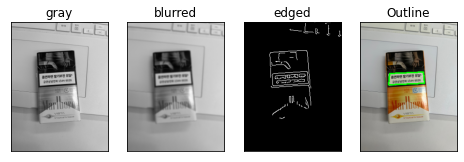

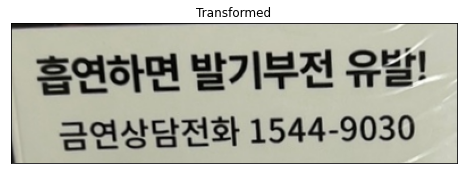

In [ ]:
cigarette_image = make_scan_image(org_image, width = 200, ksize = (5, 5), min_threshold = 150, max_threshold = 200)

In [ ]:
run_ocr(cigarette_image, lang = 'kor+eng')

[INFO] OCR 결과 :
흡연하면 발기부전 유발!

 금연상담전화 1544-9030

